### Future notes and questions

Think about AM as an optimization problem, does the dynamics that we've used make sense? If good mutations are entropically limited, but every good mutation leads to a promising endpoint, then this may be reasonable. If not all beneficial mutations have high potential to develop further, then maybe it would be better to first build greater diversity with low selection strength (e.g. through abundant T cell help), then turn up the selection strength, analogous to simulated annealing. Think about the rate of generating beneficial mutations: rate of mutation $\times$ probability of CDR mutation $\times$ probability affinity-affecting $\times$ probability beneficial. Are AM simulations robust to changes in this probability? If not, then this may be a good reason to think of alternate routines.

### Sanity checking

Let's read in the output from am.py and check the average cycle length, fraction of GCs that were successful versus the ones that died, and the output of all the trajectories.

In [2]:
%matplotlib inline

import csv
import numpy as np
import scipy.stats as st
import operator as op
import matplotlib.pyplot as plot
import seaborn as sns

def selectObservations(observations, keys, values):
    
    # Sanity check
    assert len(keys)==len(values), 'Mistmatched lengths for selectObservations!'
    
    # Return a list of the observations that satisfy a certain set of conditions
    selected = []
    for obs in observations:
        allowed = True
        for i in range(len(keys)):
            if obs[keys[i]]!=values[i]:
                allowed = False
                break
        if allowed: selected.append(obs)
    
    return selected

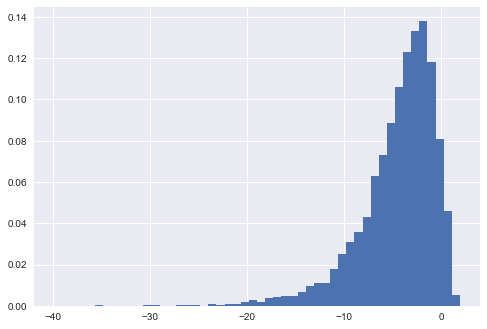

percentage of beneficial mutations = 5.910000
percentage of bad mutations = 94.090000
-4.49637273628 -3.61668243599


In [4]:
x = 3 - np.exp(np.random.normal(1.9, 0.5, 10000))
fig = plot.figure()
n, bins, patches = plot.hist(x, 50, normed=1)
plot.show()
p_good = np.sum(x>0)/float(len(x)) * 100.
p_bad = np.sum(x<0)/float(len(x)) * 100.
print('percentage of beneficial mutations = %lf' % p_good)
print('percentage of bad mutations = %lf' % p_bad)
print(np.mean(x),np.median(x))

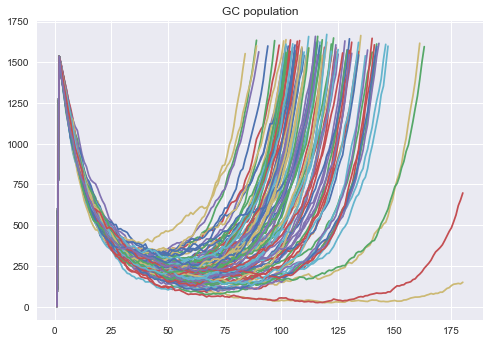

100 out of 100 GCs succeeded.


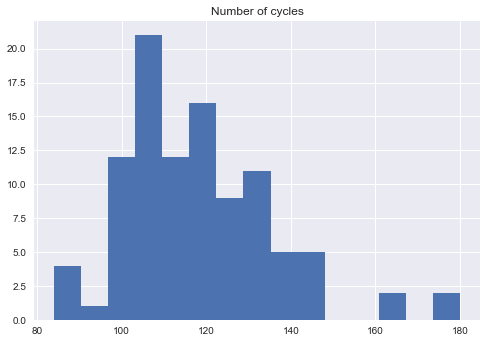

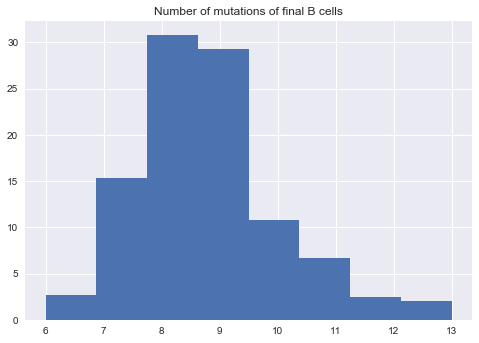

In [41]:
# lognormal
reader    = csv.DictReader(open('output-total.csv'))
allTable  = [obs for obs in reader]
reader    = csv.DictReader(open('output-memory.csv'))
cellTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.title('GC population')
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles, 15)
plot.title('Number of cycles')
plot.show()

nMutations = []
weights    = []
for i in range(nTrials):
    tTable = selectObservations(cellTable, ['trial'], [str(i)])
    total  = float(np.sum([int(o['number']) for o in tTable]))
    for o in tTable:
        nMutations.append(int(o['CDR_mutations']))
        weights.append(float(o['number'])/total)

fig = plot.figure()
n, bins, patches = plot.hist(nMutations, 1 + np.max(nMutations) - np.min(nMutations), weights=weights)
plot.title('Number of mutations of final B cells')
plot.show()

The maximal growth rate $m$ per cycle of a homogeneous population of B cells in the germinal center (GC) is given roughly by 

$$ m = 4 (1-\mu)^2 r \,, $$

where $\mu$ is the death rate and $r$ is the recycling rate. The leading factors of 4 and $(1-\mu)^2$ are present because the cells undergo two rounds of division and mutation per GC cycle: from c, proba that daughter c1 survives is $(1-\mu)$ and proba that granddaughter c11 survives is $(1-mu)^2$. The proba that all 4 granddaughter cells are additive so $4 (1-\mu)^2$.

In the earliest stages of the GC the initial founder population decays by a factor of $m s_0$ per cycle, where $s_0$ is the fraction of founder B cells that successfully internalize antigen and thus survive this selection step. $$ s_0 = \frac{conc}{1+conc}$$

How many beneficial mutants are generated from the founder population until it dies out? The rough number of cycles $c$ needed for the founders to die out is

$$ c = -\frac{\log{N_0}}{\log{m s_0}} \,, $$

where $N_0$ is the size of the starting population of B cells. The population at cycle $c$, equals $N_0 (ms_0)^c$. Assuming that the founder population dies out when the population is equal to or smaller than 1, we get $$N_0 (ms_0)^c = 1$$

The energy required to have a flat decay rate is the solution to 
$$ m \frac{conc \exp{(e_{scale}E_h)}}{1+ conc \exp{(e_{scale}E_h)}} = 1 $$

which gives $$ E_h = -\frac{\log(m-1) + log(conc)}{e_{scale}} $$

In [42]:
N0           = 1536
p_mut        = 0.2
p_CDR        = 1
p_FR         = 1 - p_CDR
p_CDR_lethal = 0.3
p_CDR_bad    = 0.2 *0.95
p_FR_lethal  = 1
help_cutoff  = 0.70
p_recycle    = 0.70
energy_scale = 0.035
conc         = 1.20
p_bind0      = conc / (1 + conc)
p_death      = p_mut * ((p_CDR * (p_CDR_lethal + p_CDR_bad)) + (p_FR * p_FR_lethal))
m            = 4 * (1 - p_death) * (1 - p_death) * help_cutoff * p_recycle

Eh  = (-(np.log(m-1)+np.log(conc))/energy_scale)
cyc = -np.log(N0)/np.log(m * p_bind0)

print('energy required for homeostasis Eh = %lf' % Eh)
print('number of cycles before founders die out = %lf' % cyc)
print('probability of death = %lf' % p_death)

energy required for homeostasis Eh = 9.641070
number of cycles before founders die out = 52.604769
probability of death = 0.098000


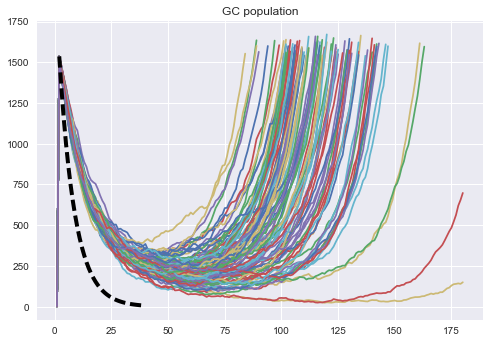

100 out of 100 GCs succeeded.


In [43]:
# Sanity checking
reader    = csv.DictReader(open('output-total.csv'))
allTable  = [obs for obs in reader]
reader    = csv.DictReader(open('output-memory.csv'))
cellTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
x = np.arange(2, 40, 1)
y = 1536. * (4 * 0.7 * 0.7 * 0.9**2 * (1.2 / 2.2))**(x - 2.) 
# 2 divisions so 4 cells * t-cell help * recycle * proba of no mutation or good mutation * c/(1+c) 
# c/(1+c) is langmuir binding formula for small binding energies
plot.plot(x, y, color='black', lw=4, ls='--')
plot.title('GC population')
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

## SINGLE ANTIGEN CASE: 
conc = 1.20, e_scale = 0.035, p_rec = 0.70, p_help = 0.70

time ~ 2.5s/trial

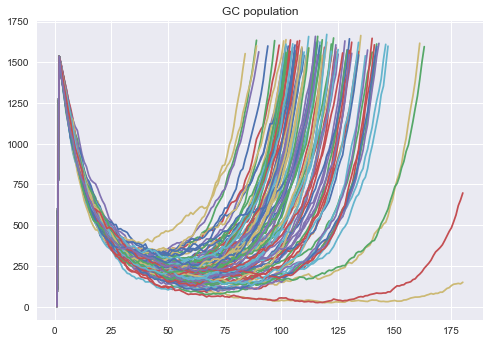

100 out of 100 GCs succeeded.


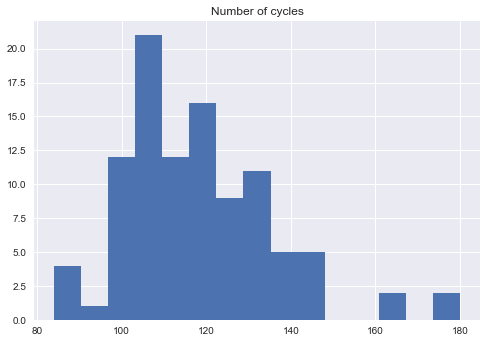

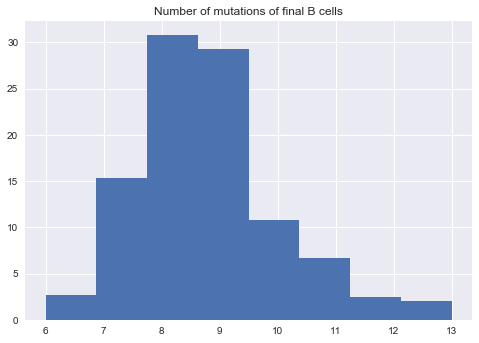

In [44]:
# lognormal
reader    = csv.DictReader(open('1Ag-output-total.csv'))
allTable  = [obs for obs in reader]
reader    = csv.DictReader(open('1Ag-output-memory.csv'))
cellTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.title('GC population')
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles, 15)
plot.title('Number of cycles')
plot.show()

nMutations = []
weights    = []
for i in range(nTrials):
    tTable = selectObservations(cellTable, ['trial'], [str(i)])
    total  = float(np.sum([int(o['number']) for o in tTable]))
    for o in tTable:
        nMutations.append(int(o['CDR_mutations']))
        weights.append(float(o['number'])/total)

fig = plot.figure()
n, bins, patches = plot.hist(nMutations, 1 + np.max(nMutations) - np.min(nMutations), weights=weights)
plot.title('Number of mutations of final B cells')
plot.show()

TESTING COCKTAIL: cocktail = Ag0 (no [ ]), conc = 1.20, e_scale = 0.035, p_rec = 0.70, p_help = 0.70

time ~ 2.44s/trial

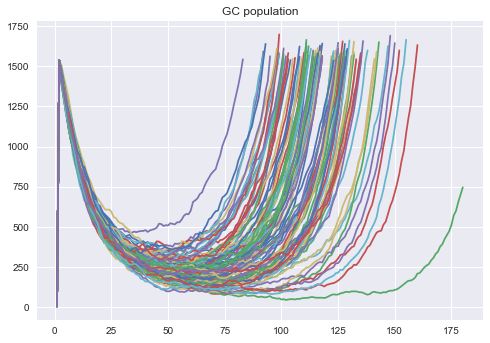

100 out of 100 GCs succeeded.


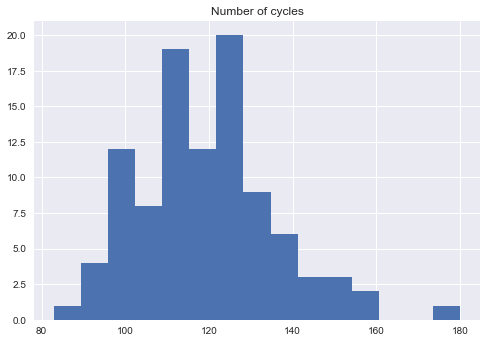

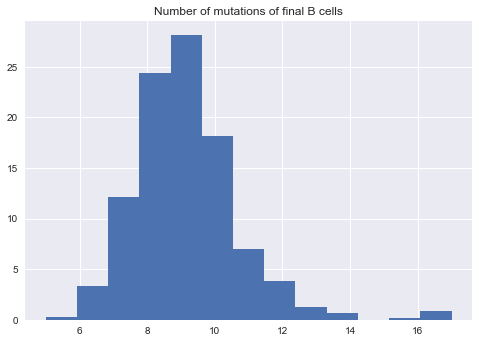

In [60]:
# lognormal
reader    = csv.DictReader(open('Ag0_cocktail_no_brackets-output-total.csv'))
allTable  = [obs for obs in reader]
reader    = csv.DictReader(open('Ag0_cocktail_no_brackets-output-memory.csv'))
cellTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.title('GC population')
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles, 15)
plot.title('Number of cycles')
plot.show()

nMutations = []
weights    = []
for i in range(nTrials):
    tTable = selectObservations(cellTable, ['trial'], [str(i)])
    total  = float(np.sum([int(o['number']) for o in tTable]))
    for o in tTable:
        nMutations.append(int(o['CDR_mutations']))
        weights.append(float(o['number'])/total)

fig = plot.figure()
n, bins, patches = plot.hist(nMutations, 1 + np.max(nMutations) - np.min(nMutations), weights=weights)
plot.title('Number of mutations of final B cells')
plot.show()

TESTING COCKTAIL: cocktail = [Ag0], conc = 1.20, e_scale = 0.035, p_rec = 0.70, p_help = 0.70

time ~ 2.69s/trial

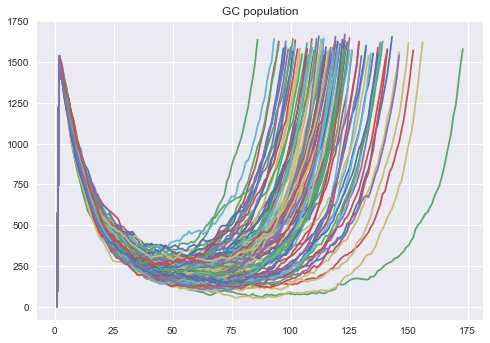

100 out of 100 GCs succeeded.


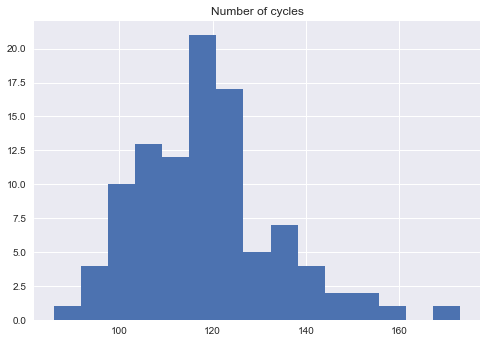

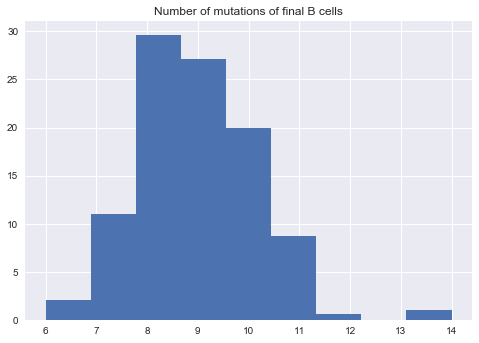

In [69]:
# lognormal
reader    = csv.DictReader(open('Ag0_cocktail_w_brackets-output-total.csv'))
allTable  = [obs for obs in reader]
reader    = csv.DictReader(open('Ag0_cocktail_w_brackets-output-memory.csv'))
cellTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.title('GC population')
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles, 15)
plot.title('Number of cycles')
plot.show()

nMutations = []
weights    = []
for i in range(nTrials):
    tTable = selectObservations(cellTable, ['trial'], [str(i)])
    total  = float(np.sum([int(o['number']) for o in tTable]))
    for o in tTable:
        nMutations.append(int(o['CDR_mutations']))
        weights.append(float(o['number'])/total)

fig = plot.figure()
n, bins, patches = plot.hist(nMutations, 1 + np.max(nMutations) - np.min(nMutations), weights=weights)
plot.title('Number of mutations of final B cells')
plot.show()

## Using Mixture_project jupyter NOTEBOOK!!!!!


### TESTING COCKTAIL: 
cocktail = [Ag0,Ag1,Ag2, Ag3], d = 5, conc = 1.15, e_scale = 0.045, p_rec = 0.70, p_help = 0.70

time ~ 3.6s/trial

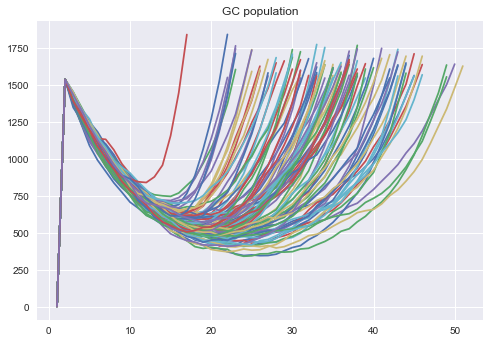

100 out of 100 GCs succeeded.


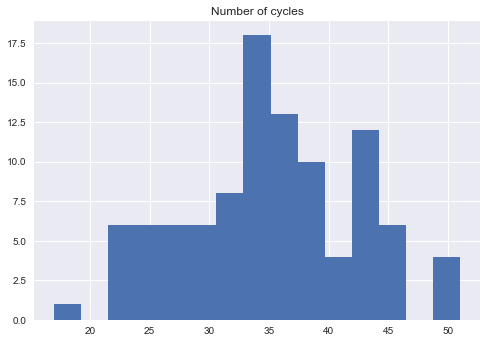

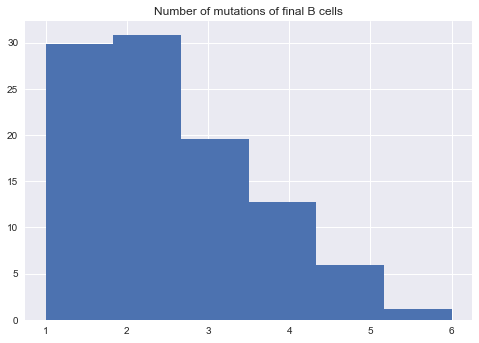

In [7]:
# lognormal
reader    = csv.DictReader(open('output-total.csv'))
allTable  = [obs for obs in reader]
reader    = csv.DictReader(open('output-memory.csv'))
cellTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.title('GC population')
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles, 15)
plot.title('Number of cycles')
plot.show()

nMutations = []
weights    = []
for i in range(nTrials):
    tTable = selectObservations(cellTable, ['trial'], [str(i)])
    total  = float(np.sum([int(o['number']) for o in tTable]))
    for o in tTable:
        nMutations.append(int(o['CDR_mutations']))
        weights.append(float(o['number'])/total)

fig = plot.figure()
n, bins, patches = plot.hist(nMutations, 1 + np.max(nMutations) - np.min(nMutations), weights=weights)
plot.title('Number of mutations of final B cells')
plot.show()

cocktail = [Ag0,Ag1,Ag2, Ag3], d = 5, conc = 1.05, e_scale = 0.035, p_rec = 0.70, p_help = 0.70
time ~ 3.6s/trial

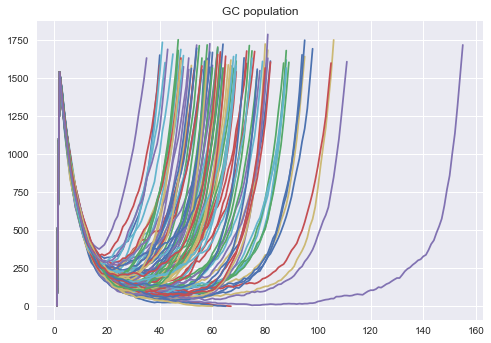

97 out of 100 GCs succeeded.


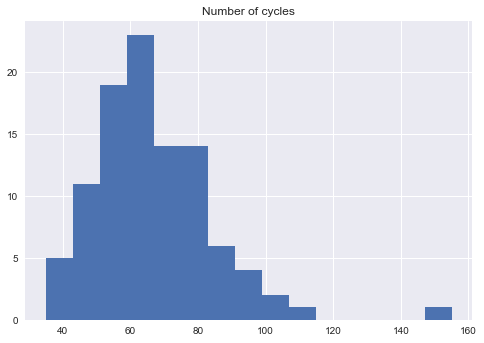

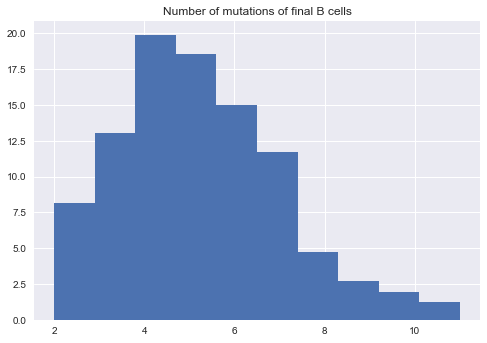

In [8]:
# lognormal
reader    = csv.DictReader(open('output-total.csv'))
allTable  = [obs for obs in reader]
reader    = csv.DictReader(open('output-memory.csv'))
cellTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.title('GC population')
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles, 15)
plot.title('Number of cycles')
plot.show()

nMutations = []
weights    = []
for i in range(nTrials):
    tTable = selectObservations(cellTable, ['trial'], [str(i)])
    total  = float(np.sum([int(o['number']) for o in tTable]))
    for o in tTable:
        nMutations.append(int(o['CDR_mutations']))
        weights.append(float(o['number'])/total)

fig = plot.figure()
n, bins, patches = plot.hist(nMutations, 1 + np.max(nMutations) - np.min(nMutations), weights=weights)
plot.title('Number of mutations of final B cells')
plot.show()

cocktail = [Ag0,Ag1,Ag2, Ag3], d = 5, conc = 1.05, e_scale = 0.030, p_rec = 0.70, p_help = 0.70
time ~ 3.6s/trial

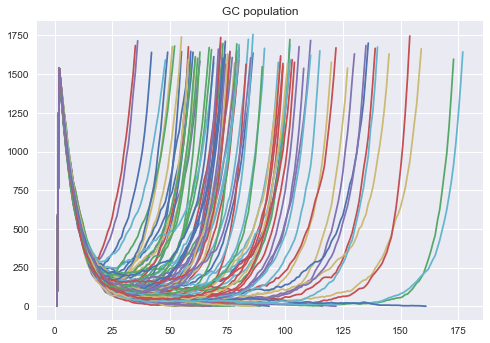

83 out of 100 GCs succeeded.


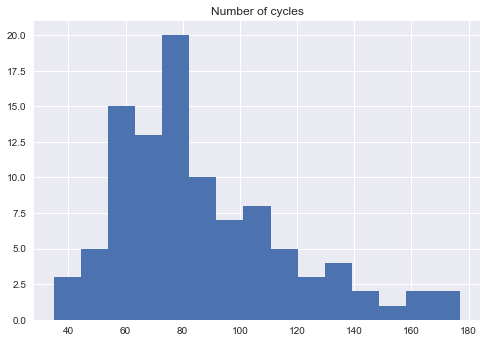

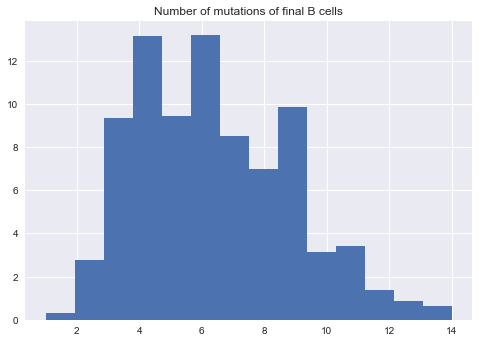

In [9]:
# lognormal
reader    = csv.DictReader(open('output-total.csv'))
allTable  = [obs for obs in reader]
reader    = csv.DictReader(open('output-memory.csv'))
cellTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.title('GC population')
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles, 15)
plot.title('Number of cycles')
plot.show()

nMutations = []
weights    = []
for i in range(nTrials):
    tTable = selectObservations(cellTable, ['trial'], [str(i)])
    total  = float(np.sum([int(o['number']) for o in tTable]))
    for o in tTable:
        nMutations.append(int(o['CDR_mutations']))
        weights.append(float(o['number'])/total)

fig = plot.figure()
n, bins, patches = plot.hist(nMutations, 1 + np.max(nMutations) - np.min(nMutations), weights=weights)
plot.title('Number of mutations of final B cells')
plot.show()